# YOLO
In yolo (you only look once) we will have B bounding boxes per pixel, and the pixels are large and cover the whole image.

The pixel in which the center of an object lies is responsible for detecting the object.

Each of the bounding boxes output is 5 numbers, (x,y) (the center, not corner) width, height, confidence.

Confidence is a prediction of IOU

Additionally, each cell predicts a probability distribution over class labels.




# Color module
We can use my attention mechanism to give some sort of a color module.

Say I have a variable number of colors N, and I want to map to a fixed number M.

We get M convolution filters.

We filter each image with each filter.  This gives an N x M array of images.

We then apply a softmax to it.  We then do matrix multiplication.



# TODO
use running mean batch norm

fix rotated bounding boxes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.collections import PolyCollection
# %matplotlib notebook
%matplotlib widget
from os import makedirs
from os.path import join
import time
from scipy.ndimage import gaussian_filter

user = 'abenneck'
# user = 'dtward'

import sys
sys.path.append('/home/abenneck/Desktop/yolo_model')

from yolo_help import iou

In [2]:
resume = True # if True, will load a saved model
if user == 'abenneck':
    outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v01'
else:
    outdir = 'yolo_saved_models_v01'
modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'
makedirs(outdir,exist_ok=True)

nclasses = 3
dtype = torch.float32

In [3]:
from yolo_help import GroundTruthDataset


groundtruth = GroundTruthDataset(reproducible = True)

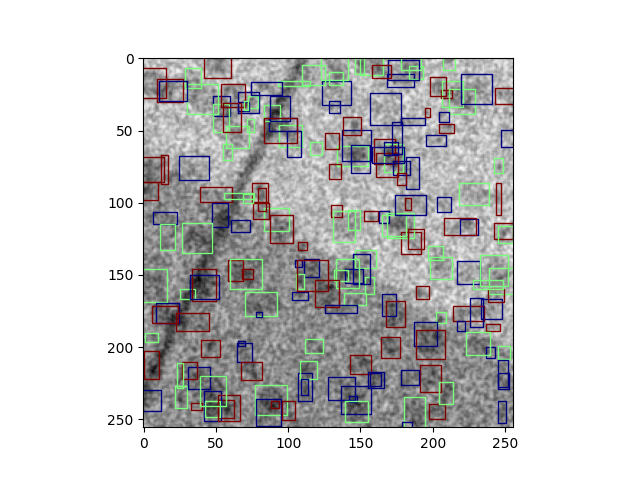

In [4]:
from yolo_help import bbox_to_rectangles, imshow


I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
#ax.imshow(I[0],cmap='gray')
imshow(I,ax,cmap='gray')
polys = bbox_to_rectangles(bbox,fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
ax.add_collection(polys)

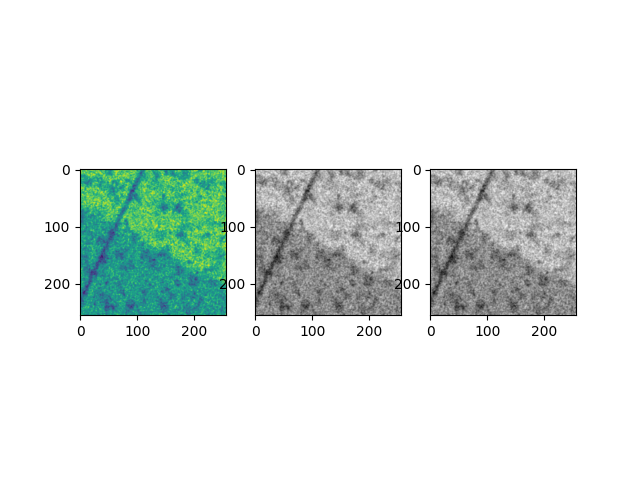

In [5]:
from yolo_help import VariableInputConv2d


layer = VariableInputConv2d(3)
fig,ax = plt.subplots(1,3)
I,bbox,cls = groundtruth[0]
imshow(I,ax[0])

r = torch.randperm(I.shape[0])
out1 = layer(torch.tensor(I,dtype=dtype)[None]).clone().detach()[0]
out2 = layer(torch.tensor(I,dtype=dtype)[r][None]).clone().detach()[0] 
imshow(out1,ax[1])
imshow(out2,ax[2])
# note the order of components doesn't matter

In [6]:
from yolo_help import Net


net = Net()
out = net(torch.tensor(I[None],dtype=dtype))
out.shape

torch.Size([1, 13, 32, 32])

In [ ]:
from yolo_help import convert_data

# we need to transform the outputs into bounding boxes
# for this we need a parameterization
# now YOLO assumes a fixed size, which I don't want to do
# my parameterization will therefore be
# xyshift (a number between -0.5 and 0.5, relative to grid size)
# hwscale (relative to grid size, )

# so we need a function to do this transformation
# number of bounding boxes
B = net.B
stride = net.stride
bboxes,data = convert_data(out,B,stride)


fig,ax = plt.subplots()
x = torch.arange(out.shape[-1])*stride + (stride-1)/2
y = torch.arange(out.shape[-2])*stride + (stride-1)/2
YX = torch.stack(torch.meshgrid(y,x,indexing='ij'),0)
ax.imshow(I[0],cmap='gray')
ax.scatter(YX[1].ravel(),YX[0].ravel(),s=1,alpha=0.5)
x = bboxes[...,0]
y = bboxes[...,1]
w = bboxes[...,2]
h = bboxes[...,3]
c = data[...,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='b',alpha=c.clone().detach()*0.5)
ax.add_collection(predicted_rectangles,)

true_rectangles = bbox_to_rectangles(bbox,fc='none',ec='r')
ax.add_collection(true_rectangles,)
fig.canvas.draw()

In [8]:
from yolo_help import get_assignment_inds


# transform the true bounding boxes
# to do this first we need an assignment to a given cell
shape = out.shape
B = net.B

assignment_inds,ious = get_assignment_inds(bboxes,bbox,shape,stride,B)
bboxes_assigned = bboxes[assignment_inds]
x = bboxes_assigned[...,0]
y = bboxes_assigned[...,1]
w = bboxes_assigned[...,2]
h = bboxes_assigned[...,3]
c = data[assignment_inds,-1]
predicted_rectangles = bbox_to_rectangles(torch.stack( (x.ravel(),y.ravel(),w.ravel(),h.ravel()) ).T,fc='none',ec='g',alpha=c.clone().detach())
ax.add_collection(predicted_rectangles,)

In [9]:
from yolo_help import get_reg_targets

# now that we have assignment inds and ious
# we also need the target regression parameters
shape = out.shape
stride = net.stride
B = net.B
    
shape = out.shape
stride = net.stride
B = net.B    
shiftx,shifty,scalex,scaley = get_reg_targets(assignment_inds,bbox,B,shape,stride)

In [10]:
# if user == 'abenneck':
#     J = plt.imread('/home/abenneck/Desktop/yolo_model/section_000197_30800.jpeg')
# else:
#     J = plt.imread('/home/dtward/data/AllenInstitute/ARA/section_000197_30800.jpeg')

# J= J[...,:3]
# if J.dtype == np.uint8:
#     J = J / 255.0
# J = J.transpose((-1,0,1))
# #J = np.mean(J,-1)
# fig,ax = plt.subplots()
# imshow(J[:,::8,::8],ax)

In [ ]:
from yolo_help import train_yolo_model

if user == 'abenneck':
    J_path = '/home/abenneck/Desktop/yolo_model/section_000197_30800.jpeg'
else:
    J_path = '/home/dtward/data/AllenInstitute/ARA/section_000197_30800.jpeg'

nepochs = 1500
lr = 1e-4
cls_loss = torch.nn.CrossEntropyLoss(reduction='sum')
resume = True # if True, will load a saved model
groundtruth = GroundTruthDataset(reproducible = True)

modelname = 'modelsave.pt'
optimizername = 'optimizersave.pt'
lossname = 'loss.pt'

if user == 'abenneck':
    if resume:
        outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v01'
    else:
        outdir = '/home/abenneck/Desktop/YOLO/yolo_saved_models_v02'
else:
    outdir = 'yolo_saved_models_v01'

net = train_yolo_model(J_path, nepochs, lr, cls_loss, outdir, modelname, optimizername, lossname, resume)

In [12]:
# What to add
# I wasn't sure if the outputcan make more than one prediction per grid cell in evaluation mode.
# for now we're doing one prediction per grid cell in evaluation mode.
# 1. Set up a repo on twardlab (and add me to it)
# 2. Move all the functions and models into a .py file.  Keep the training in the notebook.  i.e.
#    any time this notebook has a "def" or a "class", that will be replaced by an import statement from 
#   the py file.
# 3. Make another notebook that loads the saved model and does prediction (this is how people will use it).
# 4. Add a tool for doing NMS, and a tool for calculating precision recall curves. Maybe you used an existing 
#    implementation in scikit learn.

# Post-Processing

### Filter candidate bboxes (best_bbox_per_cell + NMS)

In [14]:
from yolo_help import get_best_bounding_box_per_cell

# bbox = [cx, cy, w, h, conf]
I,bbox,cls = groundtruth[0]
out = net(torch.tensor(I,dtype=dtype)[None])
bboxes,data = convert_data(out,net.B,net.stride)
scores = data[:,-1]
print(f'{len(bboxes)} bboxes output from model')

# Reduces # of guesses by factor of 2
bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores.clone().detach(),net.B)
print(f'{len(bboxes_)} bboxes after getting best bbox per cell')

# Perform NMS on filtered guesses
start = time.time()
bboxes_,scores_ = NMS(bboxes_, scores_)
print(f'{len(bboxes_)} bboxes after NMS; Finished in {time.time() - start:.2f}s')

2048 bboxes output from model
1024 bboxes after getting best bbox per cell
491 bboxes after NMS; Finished in 117.25s


### Compare GT bounding boxes with filtered estimated bounding boxes

Text(0.5, 1.0, 'Estimate')

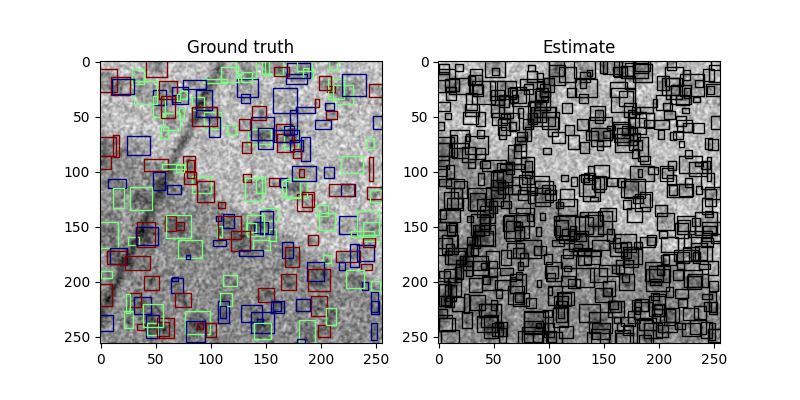

In [15]:
I,bbox,cl = groundtruth[0]
fig,axs = plt.subplots(1,2)
fig.set_size_inches(8,4)

imshow(I,axs[0],cmap='gray')
polys = bbox_to_rectangles(np.asarray(bbox),fc='none')
polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
axs[0].add_collection(polys)
axs[0].set_title('Ground truth')

imshow(I,axs[1],cmap='gray')
polys = bbox_to_rectangles(np.asarray(bboxes_),fc='none')
# polys.set_edgecolor(plt.cm.jet(cl*255//(nclasses-1)))
axs[1].add_collection(polys)
axs[1].set_title('Estimate')

## PR Curve Generation

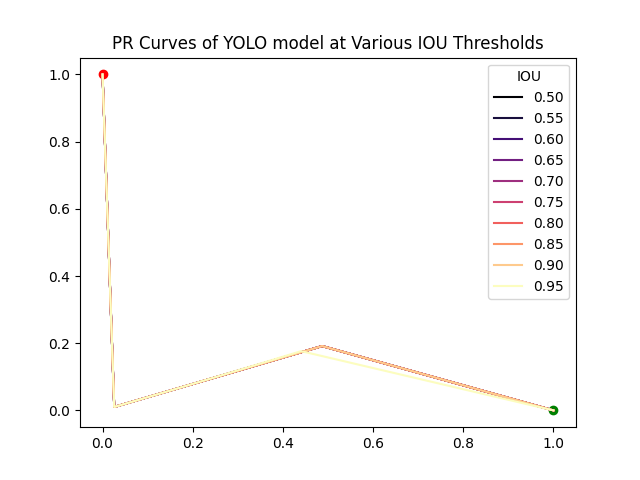

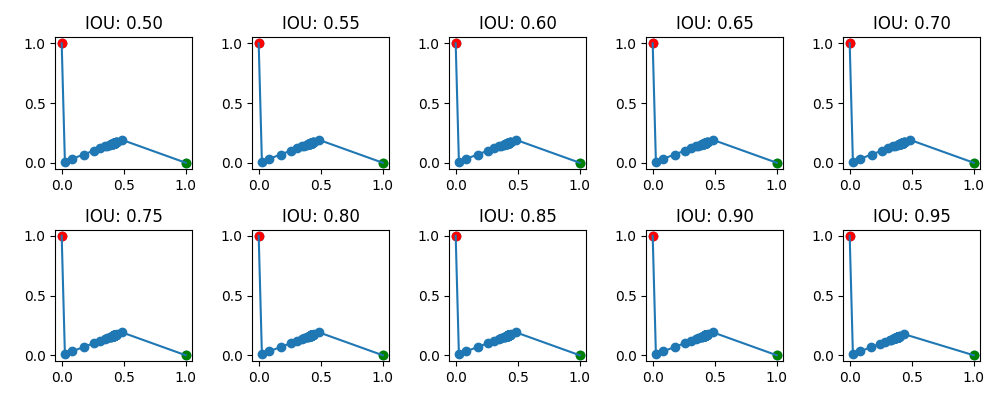

mAP: 0.10788976891914207


In [34]:
import importlib as imp
import yolo_post_help
imp.reload(yolo_post_help)
from yolo_post_help import compute_pr_curves, plot_pr_curves, get_mAP

groundtruth = GroundTruthDataset(reproducible = True)
I,bbox,cl = groundtruth[0]
out = compute_pr_curves(bbox, bboxes_, scores_, verbose = True)
fig, axs = plot_pr_curves(out)
fig, axs = plot_pr_curves(out, condense = False)
mAP = get_mAP(out)    
print(f'mAP: {mAP}')

### Daniel's Scratch Work

In [ ]:
import tifffile
K = tifffile.imread('/panfs/dong/RNAscope/SW230926-02A/TIFFS/SW230926-02A_1_16.tif')
K = K / np.max(K,axis=(-1,-2),keepdims=True)
K = K[...,::2,::2]
#K = K[0,None]
print(K.shape)

In [ ]:
fig,ax= plt.subplots()
imshow(K[...,::8,::8],ax)

In [ ]:
# another image to try
fig2,ax2 = plt.subplots(3,3,figsize=(9,9))
fig2.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.1,wspace=0.1)

net.eval()
n = 128
stride = 1024
for r in range(3):
    for c in range(3):
        ax1[r,c].cla()
        sl = (slice(r*stride+stride,r*stride+stride+n),slice(c*stride+stride,c*stride+stride+n))
        out = net(torch.tensor(K[(slice(None),)+sl][None],dtype=torch.float32))

        # convert the data into bbox format
        bboxes,data = convert_data(out,net.B,net.stride)

        #ax1[r,c].imshow(J[sl],cmap='gray')
        #imshow(K[sl],ax2[r,c])
        #imshow(net.color.out.clone().detach()[0],ax1[r,c])
        imshow(net.color.out.clone().detach()[0],ax2[r,c])

        classprobs = out[:,-nclasses:].reshape(nclasses,-1)
        p = torch.softmax(classprobs.clone().detach(),0)
        c0 = torch.tensor([1.0,0.0,0.0])
        c1 = torch.tensor([0.0,1.0,0.0])
        #colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()
        colors = 'r'
        bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,data[:,-1].clone().detach(),net.B)
        alpha = scores_.clone().detach()
        alpha = alpha * (alpha>0.5)

        ax2[r,c].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=alpha))
        ax2[r,c].axis('off')
net.train()



In [ ]:
# below here is scratch
asdf

In [ ]:
out = net(torch.tensor(J[(slice(None),)+sl][None],dtype=torch.float32))

In [ ]:
fig,ax = plt.subplots()
imshow(net.color.out.clone().detach()[0],ax)

In [ ]:
Esave

In [ ]:
fig,ax = plt.subplots()
ax.hist(mask.numpy().ravel())

In [ ]:
colors = ( (p[0]*c0[...,None]) + (p[1]*c1[...,None]) ).T.numpy()

In [ ]:
colors.shape

In [ ]:
bboxes.shape,data[:,-1].shape

In [ ]:
I.shape

In [ ]:
data_assigned.shape,shiftx.shape

In [ ]:
data.shape,shiftx.shape

In [ ]:
I,bbox,cl = groundtruth[0]
fig,ax = plt.subplots()
imshow(I,ax)

In [ ]:
I.shape

In [ ]:
I,bbox,cls = groundtruth[0]
out = net(torch.tensor(I,dtype=dtype)[None])
bboxes,data = convert_data(out,net.B,net.stride)
fig,ax = plt.subplots(1,3)
imshow(I,ax[0])
imshow(net.color.out.clone().detach()[0][0:],ax[1])
imshow(net.color.out.clone().detach()[0][0:],ax[2])

'''
scores = data[:,-1]
scores_ = scores.reshape(-1,B)
inds = torch.argmax(scores_,-1)
scores_ = torch.take_along_dim(scores_,inds[:,None],1)[...,0]

bboxes_ = bboxes.reshape(-1,B,4)
bboxes_ = torch.take_along_dim(bboxes_,inds[:,None,None],1)[:,0]
'''

scores = data[:,-1].clone().detach()

bboxes_,scores_ = get_best_bounding_box_per_cell(bboxes,scores,B)



ax[2].add_collection(bbox_to_rectangles(bboxes_,fc='none',ec=colors,ls='-',alpha=scores_.clone().detach()))


In [ ]:
a = np.random.randn(2,10)
b = np.random.randint(0,2,10)

In [ ]:
a,b

In [ ]:
np.take_along_axis(a,b[None],axis=0).shape

In [ ]:
a.shape,b.shape

In [ ]:
bboxes_.shape

In [ ]:
out